# Notebook to load and store the public AES_RD dataset

In [1]:
import h5py
import os
from matplotlib import pyplot as plt
import numpy as np

In [11]:
import scipy.io
# f = scipy.io.loadmat('/mnt/d/Data/SCA_Databases/AESRD/randomdelays-traces/ctraces_fm16x4_2.mat')
f = scipy.io.loadmat('/local/user/ldm/Data/SCA_Databases/ctraces_fm16x4_2.mat')

In [12]:
#
# brief     : Chipwhisperer tools
# author    : Lucas D. Meier (LDM)
# date      : 2022
# copyright : THIS PROGRAM IS CONFIDENTIAL AND CANNOT BE DISTRIBUTED WITHOUT 
# THE CSEM PRIOR WRITTEN AGREEMENT.
# 
import os
import pickle
from time import sleep, time
import h5py
import numpy as np
import chipwhisperer as cw
from chipwhisperer import Trace

def _initialize_h5(chip_trace,scale,nt,na,ns,fs,info,datasets_root_folder,profiling_key_type,ceiling=True):
    """ Uses the (first) trace from chip_trace to set up a h5 file. 
    
    Parameters
    ----------
    chip_trace : chipwhisperer.Traces
            The chipwhisperer traces to be saved in .h5 (often accessed via proj.traces), containing the wave, plaintexts
            (ciphertexts) and keys.
    scale : bool
            Whether to multiply each measurements by 100.
    nt : int
            How many profiling traces to use to initialize the dataset. Should be left equal to one.
    na : int, default : 0
            How many attack traces to use to initialize the dataset. Should be set to zero unless you know what you are doing.
    ns : int
            How many samples per trace to save.
    fs : int
            Offset, index of first sample in each trace to consider.
    info : str
            Information to add to the dataset filename.
    datasets_root_folder : str
            The path where to save the data.
    profiling_key_type : str
            Can be for example fresh or fixed. To be used in the filename description. Asserts whether the profiling
            traces use random(fresh) or a fixed key(s) for each Trace.
    ceiling : bool, default : True
            Whether to ceil the result to an integer.

    Returns
    -------
    str,str
                The file path / filename.
    """
    assert nt==1 and na == 0 

    raw_data = np.array(chip_trace[0],dtype=object).T
#     print(raw_data,flush=True)
    ptx= list(raw_data[1]) #tranform data representation from cwbytes to integers
#     ctx=list(raw_data[2])
    key=list(raw_data[3])
    names= ['plaintext','key']
    np_dict = np.rec.fromarrays([ptx,key],names=names)
    np_dict=np.array([np_dict])
    trace=raw_data[0][fs:fs+ns]
    if(scale):
        trace=trace*100
    if(ceiling):
        trace=np.ceil(trace*10)
        trace=trace/10
    traces=np.array([trace])
    filename ='chipData_'+profiling_key_type+'_key_'+info+'.h5'
    f = h5py.File(datasets_root_folder+filename, 'w')
    prof = f.create_group("Profiling_traces")
    prof_traces = prof.create_dataset("traces", data=traces[:nt],dtype=np.float64,chunks=True,maxshape=(None,ns))#,dtype=np.float64)
    prof_meta=prof.create_dataset("metadata",data=np_dict,chunks=True,maxshape=(None,16))
    att = f.create_group("Attack_traces")
    att_traces=att.create_dataset("traces",data=traces[nt:nt+na],dtype=np.float64,chunks=True,maxshape=(None,ns))
    att_meta=att.create_dataset("metadata",data=np_dict[nt:nt+na],chunks=True,maxshape=(None,16))
    f.close()
    return datasets_root_folder,filename
def _save_last_trace(chip_trace,file,scale,profiling, ns,fs,ceiling=True,i=0):
    """Saves the last - i trace in the given .h5 file.
    Parameters
    ----------
    chip_trace : chipwhisperer.Traces
            The chipwhisperer traces to be saved in .h5 (often accessed via proj.traces), containing the wave, plaintexts
            (ciphertexts) and keys.
    file : str
            The data file, accessed e.g. via h5py.File(datasets_root_folder+filename, 'a').
    scale : bool
            Whether to multiply each measurements by 100.
    ns : int
            How many samples per trace to save.
    fs : int
            Offset, index of first sample in each trace to consider.
    ceiling : bool, default : True
            Whether to ceil the result to an integer.
    i : int, default : 0
            Offset to save a specific trace (and not the last one).
    """

    raw_data = np.array(chip_trace[-1-i],dtype=object).T
#     print(raw_data,flush=True)
    ptx= list(raw_data[1]) #tranform data representation from cwbytes to integers
#     ctx=list(raw_data[2])
    key=list(raw_data[3])
    names= ['plaintext','key']
    np_dict = np.rec.fromarrays([ptx,key],names=names)
    np_dict=np.array([np_dict])
    
    if(scale):
        trace=raw_data[0]*100
    else:
        trace = raw_data[0]
    if(ceiling):
        trace=np.ceil(trace*10)
        trace=trace/10
    trace=np.array([trace[fs:fs+ns]])
    
    if(profiling):
        path="Profiling_traces/"
    else:
        path="Attack_traces/"
        
    file[path+'traces'].resize((file[path+'traces'].shape[0] + trace.shape[0]),axis=0)
    file[path+'traces'][-trace.shape[0]:] = trace
    file[path+'metadata'].resize((file[path+'metadata'].shape[0]+np_dict.shape[0]),axis=0)
    file[path+'metadata'][-np_dict.shape[0]:] = np_dict

def save_chip_trace_to_h5(proj,nt,na,ns=14000,fs=0,info="",datasets_root_folder="/path/to/Databases/",profiling_key_type="fresh",scale=True,ceiling=True):
    """Saves a chipwhisperer's project traces in a .h5 file. 

    The chipwhisperer's project traces have to contain nt profiling traces followed by na attack traces.
    The operation is done incrementally to avoid high CPU/RAM usage.
    Output file structure:

        [Profiling_traces/traces]
        [Profiling_traces/metadata][plaintext]
        [Profiling_traces/metadata][key]
        [Profiling_traces/metadata][ciphertext] (if exists)
        [Attack_traces/traces]
        [Attack_traces/metadata][plaintext]
        [Attack_traces/metadata][key] (if exists)
        [Attack_traces/metadata][ciphertext] (if exists)

        [Profiling_traces/metadata][masks] (if exists)
        [Profiling_traces/metadata][masks] (if exists)
    Parameters
    ----------
    proj : chipwhisperer.Project
            The project.
    nt : int
            Number of profiling traces.
    na : int
            Number of attack traces.
    ns : int, default : 14000
            Number of samples per trace. 
    fs : int, default : 0
            Offset, index of first sample in each trace to consider.
    info : str, default : ""
            Information string to add to the file.
    datasets_root_folder : str, default : "/path/to/Databases/"
            The path where to save the data.
    profiling_key_type : str, default : fresh
            Can be for example fresh or fixed. To be used in the filename description. Asserts whether the profiling
            traces use random(fresh) or a fixed key(s) for each Trace.
    scale : bool
            Whether to multiply each measurements by 100.
    ceiling : bool, default : True
            Whether to ceil the result to an integer.
    
    """
#     resync_traces = cw.analyzer.preprocessing.ResyncSAD(proj)
#     resync_traces.ref_trace = 0
#     resync_traces.target_window = (50, 150)
#     resync_traces.max_shift = 10
#     resync_analyzer = resync_traces.preprocess()
#     proj = resync_analyzer
    traces = np.array(proj.traces,dtype=object)  #this line speeds up the computation
    path,name = _initialize_h5(traces,info=str(na+nt)+"_trace_"+str(ns)+"_"+info,nt=1,na=0,ns=ns,fs=fs,datasets_root_folder=datasets_root_folder,profiling_key_type=profiling_key_type,scale=scale,ceiling=ceiling)
    sleep(1)
    try:
        file=h5py.File(path+name, 'a')
        if(nt==0):
            k=0
            profiling=False
        else:
            k=1  # 1 trace already stored in .h5 at his creation
            profiling=True
        for i in range(len(traces[k:])):
            if(i + k >nt):
                profiling=False
            _save_last_trace(traces[k:],file=file,profiling=profiling,ns=ns,fs=fs,ceiling=ceiling,i=i,scale=scale)
        file.close()
    except:
        if(os.path.exists(path+name)):
            os.remove(path+name)
        print("Error while saving traces to h5 format.")
    return name

class MockProj:
    def __init__(self,pickle_path_file):
        with open(pickle_path_file, 'rb') as pickle_file:
            self.traces = pickle.load(pickle_file)

class MockProj2:
    def __init__(self,traces):
        self.traces = np.array(traces)

# t0 = time()
# proj = MockProj("/csem.local/projects/169-SF.2284_RB2021_HW-FROSTI/TechnicalExecution/TracesLucas/aes_pros2_t50k_hd_rndkey/data.pickle")
# save_chip_trace_to_h5(proj,nt=50000,na=0,ns=372,fs=0,info="prosHD",datasets_root_folder="/path/to/Databases/",profiling_key_type="fresh",scale=False,ceiling=False)
# t1=time()
# print("duration for 50k :",t1-t0)
#CWFPGA_Pros2AES_20220623_131651.cwp

# Example usage: (may take HOURS to complete)
# path = "/csem.local/projects/169-SF.2284_RB2021_HW-FROSTI/TechnicalExecution/TracesLucas/"
# project_name = "CWFPGA_Pros2AES_20220623_131651.cwp"
# proj = cw.open_project(path + project_name)
# # mock_proj = MockProj2(proj.traces)
# save_chip_trace_to_h5(proj,nt = 50000,na = 0,ns=372,fs=0,info="Set8_sync",\
#                       datasets_root_folder="/path/to/Databases/",\
#                       profiling_key_type="fresh")


In [13]:
class MockTraces(object):
            """MockTraces : Class containing Traces
            
            Class having the same interface as chipwhisperer.analyser.Traces in order to use the chipwhisperer SNR calculation.
            """
            def __init__(self):
                self.traces=[]
            def add_trace(self,wave,ptx,key):
                self.traces.append(Trace(np.array(wave),ptx,[0]*16,key))
            def add_traces(self,waves,plains,keys):
                for w,p,k in zip(waves,plains,keys):
                    self.add_trace(w,p,k)
            def __len__(self):
                return len(self.traces)
            def __getitem__(self,idx):
                return self.traces[idx]

In [16]:
mock_traces = MockTraces()
mock_traces.add_traces(np.array(f["CompressedTraces"]).T,np.array(f["plaintext"]),np.array([keys] * 50000))
mock_proj = MockProj2(mock_traces)

/local/user/ldm/environ/lib/python3.7/site-packages/ipykernel_launcher.py:203: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [25]:
mock_proj.traces[0]

array([array([205, 189, 174, ..., 164, 165, 171], dtype=uint8),
       array([201, 204,  39,  46, 187,  82,  83, 180,  17, 166, 195, 187,  22,
       110,   7, 107], dtype=uint8),
       list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([ 43, 126,  21,  22,  40, 174, 210, 166, 171, 247,  21, 136,   9,
       207,  79,  60])], dtype=object)

In [27]:
save_chip_trace_to_h5(mock_proj,nt = 40000,na = 10000,ns=3500,fs=0,info="AES_RD_flip",\
                      datasets_root_folder="/local/user/ldm/Data/SCA_Databases/",\
                      profiling_key_type="same_")

'chipData_same__key_50000_trace_3500_AES_RD_flip.h5'

In [26]:
np.array(f["plaintext"])

array([[201, 204,  39, ..., 110,   7, 107],
       [165, 147, 225, ...,  17, 250, 213],
       [ 40,  81,  70, ..., 106, 228,   1],
       ...,
       [112,  40,  29, ...,  54, 206, 105],
       [ 22,  16,  45, ..., 164, 108,  63],
       [213, 237, 251, ..., 198,  87,  66]], dtype=uint8)

In [22]:
len(b)
b

array([[205, 189, 174, ..., 164, 165, 171],
       [189, 180, 188, ..., 178, 175, 175],
       [160, 150, 176, ..., 189, 183, 192],
       ...,
       [173, 199, 167, ..., 209, 191, 202],
       [177, 177, 202, ..., 194, 168, 168],
       [192, 179, 170, ..., 185, 186, 177]], dtype=uint8)

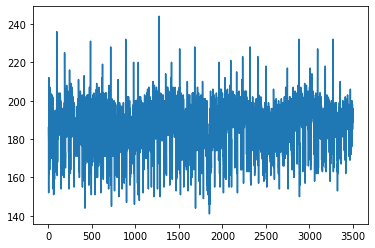

In [17]:
plt.plot(b[202])

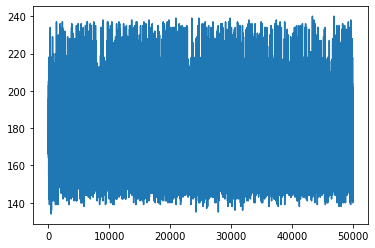

In [19]:
plt.plot(f["CompressedTraces"][12])

In [51]:
len(f["CompressedTraces"][0])

50000

In [49]:
len(f["CompressedTraces"])  #ns = 50000

3500

In [19]:
a = np.array(f["CompressedTraces"])    #nt = 3500

In [21]:
len(f["plaintext"][0])

16

In [ ]:
#ptx,ctx,key = 2b7e151628aed2a6abf7158809cf4f3c

In [8]:
int("2b7e151628aed2a6abf7158809cf4f3c",base=16)

57811460909138771071931939740208549692

In [1]:
key = 0x2b7e151628aed2a6abf7158809cf4f3c

In [8]:
masks = [(0b11111111 << 8*(15-i)) for i in range(16)]

In [9]:
keys = [(key & mask)>>8*(15-i) for i,mask in enumerate(masks)]

In [23]:
keys

[43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]

In [24]:
[keys] * 50000

[[43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60],
 [43, 126, 21, 22, 40, 174, 210, 166, 